In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Pacific_Extent = pd.read_excel(filepath, sheet_name='Pacific-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Pacific_Extent)
fp.date_time(Pacific_Extent)

,Extent,Date
0,668714.275,1979-01-01
1,566930.458,1979-02-01
2,688420.115,1979-03-01
3,859963.043,1979-04-01
4,1127120.160,1979-05-01
...,...,...
533,1134056.102,2023-06-01
534,1484824.377,2023-07-01
535,1671324.717,2023-08-01
536,1726376.097,2023-09-01


In [5]:
scaler = MinMaxScaler()
Pacific_Extent['Extent'] = scaler.fit_transform(Pacific_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 5
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Pacific_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((522, 12, 1), (522,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Pacific_model_LT5/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 26s 342ms/step - loss: 0.2019 - root_mean_squared_error: 0.4493 - val_loss: 0.1210 - val_root_mean_squared_error: 0.3479
Epoch 2/50
53/53 [==============================] - 17s 334ms/step - loss: 0.0690 - root_mean_squared_error: 0.2627 - val_loss: 0.0474 - val_root_mean_squared_error: 0.2178
Epoch 3/50
53/53 [==============================] - 16s 314ms/step - loss: 0.0505 - root_mean_squared_error: 0.2246 - val_loss: 0.0399 - val_root_mean_squared_error: 0.1999
Epoch 4/50
53/53 [==============================] - 18s 355ms/step - loss: 0.0433 - root_mean_squared_error: 0.2082 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1768
Epoch 5/50
53/53 [==============================] - 18s 339ms/step - loss: 0.0324 - root_mean_squared_error: 0.1800 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1488
Epoch 6/50
53/53 [==============================] - 19s 359ms/step - loss: 0.0248 - root_mean_squared_error: 0.1575 - val_loss: 0.0130 

53/53 [==============================] - 3s 47ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0635
Epoch 32/50
53/53 [==============================] - 3s 50ms/step - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625
Epoch 33/50
53/53 [==============================] - 3s 49ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640
Epoch 34/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628
Epoch 35/50
53/53 [==============================] - 20s 380ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 36/50
53/53 [==============================] - 17s 333ms/step - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0037 - val_root_mea

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

8.744015777111054 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

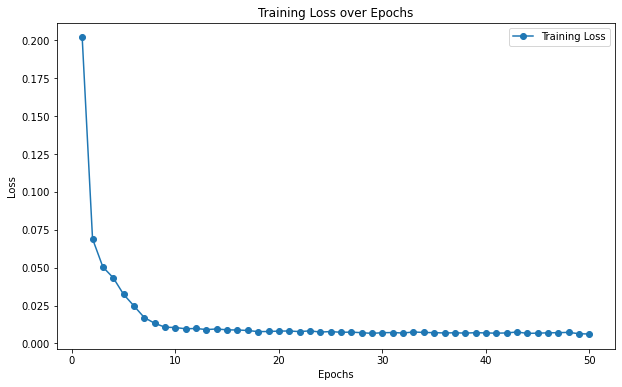

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

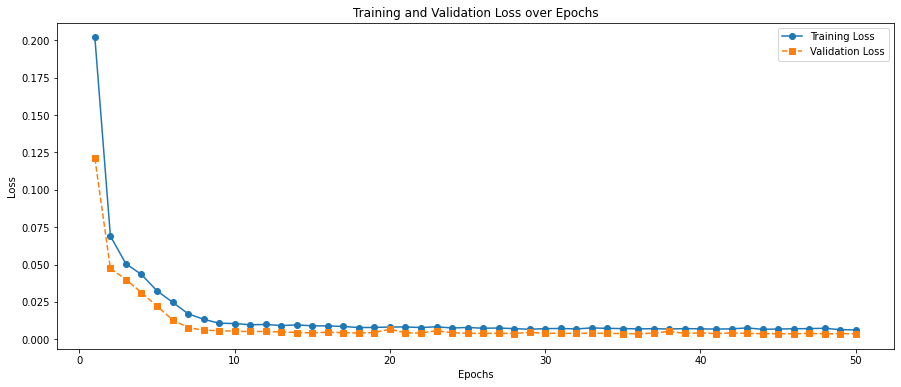

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Pacific_model_LT5/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 22ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.07280388155072222
MAE : 0.058310940957345514


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.825936e+06,2203401.829
1,1.744597e+06,1960480.542
2,1.440061e+06,1264318.504
3,8.657927e+05,863206.294
4,4.009988e+05,635624.004
5,3.334555e+05,460009.672
6,4.562045e+05,610848.036
7,7.307569e+05,819257.445
8,1.068229e+06,1129627.707
9,1.390875e+06,1463383.236


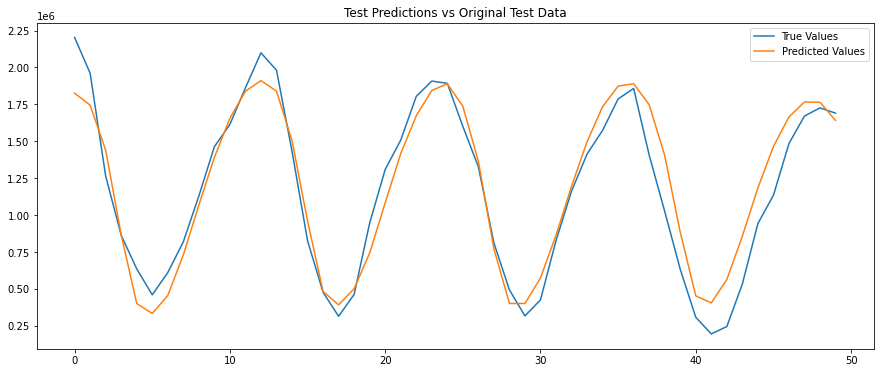

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 25ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

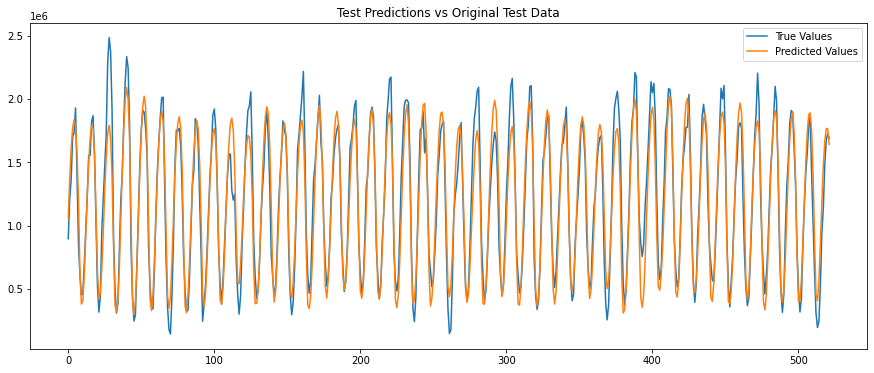

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()